In [63]:
%matplotlib inline
import numpy as np
import pandas as pd
import time
from keras import layers
from keras import models
from keras import optimizers
from keras import callbacks
from keras import backend as K
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import compose
import pathlib

In [64]:
COORDINATES = ["Xmin", "Ymin", "Xmax", "Ymax"]

In [65]:
answers = pd.read_csv("../raw/train_answers.csv").set_index("itemId")
answers.columns = COORDINATES
scaler = preprocessing.StandardScaler().fit(np.vstack([answers.values, answers.values[:, [2, 3, 0, 1]]]))
answers[COORDINATES] = scaler.transform(answers[COORDINATES])

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [66]:
votes = pd.read_csv("../raw/train_data.csv").set_index("itemId")
votes[COORDINATES] = scaler.transform(votes[COORDINATES])

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  


In [67]:
votes_test = pd.read_csv("../raw/test_data.csv").set_index("itemId")
votes_test[COORDINATES] = scaler.transform(votes_test[COORDINATES])

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  


In [93]:
def yield_batch(data):
    votes, answers = data
    item_ids = list(set(votes.index))
    while True:
        item_id = np.random.choice(item_ids, 1)
        forecasts = votes.loc[item_id]
        x = np.zeros((1, *forecasts.shape))
        y = np.zeros((1, 4))
        x[0] = forecasts.sample(len(forecasts))
        y[0] = answers.loc[item_id]
        yield x, y

In [89]:
def yield_batch_val(data):
    votes, answers = data
    item_ids = set(votes.index)
    while True:
        for item_id in item_ids:
            forecasts = votes.loc[item_id]
            x = np.zeros((1, *forecasts.shape))
            y = np.zeros((1, 4))

            x[0] = forecasts
            y[0] = answers.loc[item_id]
            yield x, y

In [70]:
def yield_batch_test(data):
    item_ids = data.index.unique()
    for item_id in item_ids:
        forecasts = data.loc[item_id]
        x = np.zeros((1, *forecasts.shape))
        y = np.zeros((1, 4))
        x[0] = forecasts
        yield x

In [71]:
def intersection_over_union(boxes_pred, boxes_true):

    x_min = K.stack([boxes_pred[:, 0], boxes_true[:, 0]], axis=-1)
    y_min = K.stack([boxes_pred[:, 1], boxes_true[:, 1]], axis=-1)
    x_max = K.stack([boxes_pred[:, 2], boxes_true[:, 2]], axis=-1)
    y_max = K.stack([boxes_pred[:, 3], boxes_true[:, 3]], axis=-1)

    x_min = K.max(x_min, axis=-1)
    y_min = K.max(y_min, axis=-1)
    x_max = K.min(x_max, axis=-1)
    y_max = K.min(y_max, axis=-1)

    zeros = K.zeros_like(x_max)

    x_inter = K.stack([zeros, x_max - x_min], axis=-1)
    y_inter = K.stack([zeros, y_max - y_min], axis=-1)

    x_inter = K.max(x_inter, axis=-1)
    y_inter = K.max(y_inter, axis=-1)
    inter_area = x_inter * y_inter
    
    area_pred = (K.max(K.stack([zeros, boxes_pred[:, 2] - boxes_pred[:, 0]], axis=-1), axis=-1) * 
                 K.max(K.stack([zeros, boxes_pred[:, 3] - boxes_pred[:, 1]], axis=-1), axis=-1))
    area_true = (K.max(K.stack([zeros, boxes_true[:, 2] - boxes_true[:, 0]], axis=-1), axis=-1) * 
                 K.max(K.stack([zeros, boxes_true[:, 3] - boxes_true[:, 1]], axis=-1), axis=-1))

    iou = inter_area / (area_pred + area_true - inter_area + K.epsilon())
    
    return -K.mean(iou, axis=-1)

In [126]:
def make_model(filters, input_shape, conv_l=6):
    K.clear_session()
    
    y = x = layers.Input(shape=(None, input_shape))
    
    y_hot = layers.Lambda(lambda z: z[:, :, :-4])(y)
    y_coor = layers.Lambda(lambda z: z[:, :, -4:])(y)
    
    y_hot = layers.Dropout(0.9)(y_hot)  # 0.15 новых
    y_hot = layers.Dense(units=1, activation=None)(y_hot)
    
    y = layers.concatenate([y_hot, y_coor])
    
    for i in range(conv_l):
        y = layers.Conv1D(
            filters=filters,
            kernel_size=3,
            strides=1,
            padding="same"
        )(y)
    
    y = layers.GlobalAveragePooling1D()(y)
    
    y = layers.Dense(
        units=filters // 2,
        activation="relu"
    )(y)
    y = layers.Dense(
        units=4,
        activation=None
    )(y)
    
    model = models.Model(inputs=x, outputs=y)
    model.summary()
    return model

In [73]:
class MaxLRTest(callbacks.Callback):

    def __init__(self, base_lr=1.0e-9, max_lr=10, steps=10000):
        super().__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.steps = steps
        
        self.iterations = None
        self.history = None
        
    def clr(self):
        return self.base_lr * (self.max_lr / self.base_lr) ** (self.iterations / self.steps) 
  
    def on_train_begin(self, logs=None):
        self.iterations = 0
        self.history = {}
        K.set_value(self.model.optimizer.lr, self.base_lr)     
            
    def on_batch_end(self, batch, logs=None):
        if self.iterations > self.steps:
            self.model.stop_training = True
        
        self.history.setdefault("iterations", []).append(self.iterations)
        self.history.setdefault("lr", []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        self.iterations += 1
        K.set_value(self.model.optimizer.lr, self.clr())
        
    def plot(self, smooth=None, t_score=2):
        smooth = int(smooth or self.steps // 10)
        df = pd.DataFrame(self.history).set_index("lr").loss.rolling(smooth).agg(["mean", "std"])
        df["std"] = df["mean"] + t_score * df["std"] / smooth ** 0.5
        print(f"Max speed learning rate  - {df['std'].idxmin():.1e}")
        df.plot(logx=True, figsize=(16, 8))

In [74]:
class DecayingLR(callbacks.Callback):

    def __init__(self, max_lr=0.1, warm_up=1, decay_per_epoch=1, epsilon=0.0001, wait=3):
        super().__init__()

        self.max_lr = max_lr
        self.warm_up = warm_up
        self.decay_per_epoch = decay_per_epoch
        self.epsilon=epsilon
        self.wait=wait
        
        self.iterations = None
        self.history = None
        
        self.d_loss_iterations = None
        self.d_loss = None
        self.d_iterations = None
        self.d_iterations2 = None
        self.d_1 = None
                
        self.steps = None
        self.decay = None
        
        self.wait_count=None
        self.prev_loss=None

    def on_train_begin(self, logs=None):
        self.iterations = 1
        self.history = {}
        
        self.d_loss_iterations = 0.0
        self.d_loss = 0.0
        self.d_iterations = 0.0
        self.d_iterations2 = 0.0
        self.d_1 = 0.0
        
        self.steps = self.params["steps"]
        self.decay = (1 - 1 / self.steps) ** (1 / self.decay_per_epoch)
        
        self.wait_count=0
        self.prev_loss=None
        
        K.set_value(self.model.optimizer.lr, self.lr())
    
    def make_decay(self, old, new):
        decay = self.decay
        return old * decay + new * (1 - decay)
    
    def lr(self):
        warm_up = self.iterations / self.steps * self.warm_up
        if warm_up <= 1:
            return self.max_lr * warm_up 
        
        lr = self.history["lr"][-1]
        speed = self.history["speed"][-1]
        
        if speed > 0:
            return lr * self.decay
        
        return lr
            
    def on_batch_end(self, batch, logs=None):
        self.history.setdefault("iterations", []).append(self.iterations)
        self.history.setdefault("lr", []).append(K.get_value(self.model.optimizer.lr))
        
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        self.d_loss_iterations = self.make_decay(self.d_loss_iterations, logs["loss"] * self.iterations)
        self.d_loss = self.make_decay(self.d_loss, logs["loss"])
        self.d_iterations = self.make_decay(self.d_iterations, self.iterations)
        self.d_iterations2 = self.make_decay(self.d_iterations2, self.iterations ** 2)
        self.d_1 = self.make_decay(self.d_1, 1)
        
        cov = self.d_loss_iterations - self.d_loss * self.d_iterations / self.d_1
        var = self.d_iterations2 - self.d_iterations ** 2 / self.d_1
        
        speed = self.steps * cov / var
        self.history.setdefault("speed", []).append(speed)
        
        self.iterations += 1
        K.set_value(self.model.optimizer.lr, self.lr())     
        
    def on_epoch_end(self, epoch, logs=None):
        lr = self.history["lr"][-1]
        speed = self.history["speed"][-1]
        print(f"Learning rate: {lr:.1e}")
        print(f"Speed per epoch: {speed:.4f}")
        
        if self.prev_loss is None:
            self.prev_loss = logs["val_loss"]
        elif abs(self.prev_loss - logs["val_loss"]) < self.epsilon:
            self.wait_count += 1
        else:
            self.wait_count = 0
        self.prev_loss = logs["val_loss"]
        print(f"Wait to stop: {self.wait - self.wait_count}\n")
        if self.wait == self.wait_count:
            self.model.stop_training = True
        
    def plot(self, smooth=None):
        smooth = int(smooth or self.steps)
        df = pd.DataFrame(self.history).set_index("iterations")[["loss", "lr"]].rolling(smooth).mean()
        df.plot(figsize=(16, 8), secondary_y="lr")

In [122]:
def train_model(data_train, data_val, units, test=False):
    
    max_lr = 4.5e-04
    
    steps_per_epoch = 1000
    epochs = 100
    
    model = make_model(units, data_train[0].shape[1])  
    
    model.compile(optimizer=optimizers.Nadam(lr=max_lr / 100, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004),
                      loss="mae",
                      metrics=[intersection_over_union]
        )
    rez = model.fit_generator(
            yield_batch(data_train),
            steps_per_epoch=1000,
            epochs=1,
            callbacks=None,
            validation_data=yield_batch_val(data_val),
            validation_steps=len(data_val[1].index),
        )
    
    
    model.compile(optimizer=optimizers.Nadam(lr=max_lr, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004),
                  loss=intersection_over_union,
                  metrics=None
    )
    cycle = MaxLRTest() if test else DecayingLR(max_lr=max_lr)
    cb = [
        callbacks.ModelCheckpoint("../processed/model.h5", monitor="val_loss", verbose=1, save_best_only=True),
        cycle
    ]
    rez = model.fit_generator(
        yield_batch(data_train),
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        callbacks=cb,
        validation_data=yield_batch_val(data_val),
        validation_steps=len(data_val[1].index),
        )
    
    model = models.load_model("../processed/model.h5", custom_objects={"intersection_over_union": intersection_over_union})
    
    return rez, cycle, model

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 1361)   0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, None, 1357)   0           input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, None, 1357)   0           lambda_1[0][0]                   
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, None, 1)      1358        dropout_1[0][0]                  
__________________________________________________________________________________________________
lambda_2 (

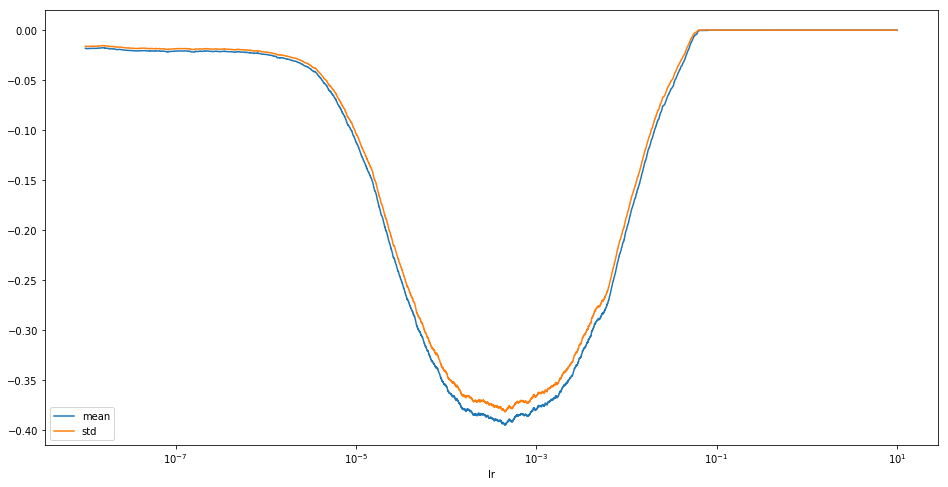

In [121]:
a, *_ = transform(votes, votes, votes)
train_model((a, answers), (a, answers), 64, True)[1].plot()

In [80]:
def transform(train, val, test):
    trans = compose.ColumnTransformer(
        [("onehot_id", preprocessing.OneHotEncoder(handle_unknown="ignore"), [0])],
        remainder="passthrough",
        sparse_threshold=0
    )
    train = pd.DataFrame(trans.fit_transform(train), index=train.index)
    val = pd.DataFrame(trans.transform(val), index=val.index)
    test = pd.DataFrame(trans.transform(test), index=test.index)
    return train, val, test

In [128]:
FOLDS = 10

def train_oof(train_set, test_set, units=64):
    x_train, y_train = train_set
    x_test = test_set

    y_oof = pd.DataFrame(0, index=y_train.index, columns=COORDINATES)
    y_pred = pd.DataFrame(0, index=x_test.index.unique(), columns=COORDINATES)
    scores = []
    folds = model_selection.KFold(n_splits=FOLDS, shuffle=True)
    
    for n, (index_train, index_valid) in enumerate(folds.split(y_train), 1):
        print(f"\nFold - {n} / {FOLDS}")
        
        ids_train = y_train.index[index_train]
        ids_valid = y_train.index[index_valid]
        
        x_train_t, x_val_t, x_test_t = transform(x_train.loc[ids_train], x_train.loc[ids_valid], x_test)
        
        data_train = (x_train_t, y_train.loc[ids_train])
        data_val = (x_val_t, y_train.loc[ids_valid])
        
        rez, cycle, model = train_model(data_train, data_val, units)
        
        cycle.plot()
        pd.DataFrame(rez.history)[["loss", "val_loss"]].plot(figsize=(16, 8))
        scores.append(min(rez.history["val_loss"]))
        
        feat = yield_batch_test(data_val[0])
        df = model.predict_generator(feat, steps=len(data_val[0].index.unique()))
        df = scaler.inverse_transform(df)
        y_oof.loc[ids_valid] = df
        
        feat = yield_batch_test(x_test_t)
        df = model.predict_generator(feat, steps=len(x_test.index.unique()))
        df = scaler.inverse_transform(df)
        y_pred += df / FOLDS

    print(f"IOU на кроссвалидации: " + str(-np.round(sorted(scores), 5)))
    print(f"IOU среднее: {-np.mean(scores):0.5f} +/- {2 * np.std(scores) / len(scores) ** 2:0.5f}")

    subdir = time.strftime('%Y-%m-%d_%H-%M')
    path = pathlib.Path(f"../processed/{subdir}")
    path.mkdir(exist_ok=True)
    y_oof.to_csv(path / f"oof-{-np.mean(scores):0.5f}.csv", header=False)
    y_pred.to_csv(path / f"sub-{-np.mean(scores):0.5f}.csv", header=False)


Fold - 1 / 10
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 1315)   0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, None, 1311)   0           input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, None, 1311)   0           lambda_1[0][0]                   
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, None, 1)      1312        dropout_1[0][0]                  
______________________________________________________________________________________________

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 5s 5ms/step - loss: -0.3261 - val_loss: -0.3022

Epoch 00001: val_loss improved from inf to -0.30218, saving model to ../processed/model.h5
Learning rate: 4.5e-04
Speed per epoch: -0.1460
Wait to stop: 3

Epoch 2/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.3931 - val_loss: -0.4215

Epoch 00002: val_loss improved from -0.30218 to -0.42155, saving model to ../processed/model.h5
Learning rate: 4.5e-04
Speed per epoch: -0.0562
Wait to stop: 3

Epoch 3/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4274 - val_loss: -0.4337

Epoch 00003: val_loss improved from -0.42155 to -0.43365, saving model to ../processed/model.h5
Learning rate: 4.5e-04
Speed per epoch: -0.0428
Wait to stop: 3

Epoch 4/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4264 - val_loss: -0.4157

Epoch 00004: val_loss did not improve from -0.43365
Learning rate: 4.5e-04
Speed per epoch: -0.0216
Wait to st

1000/1000 [==============================] - 5s 5ms/step - loss: -0.5641 - val_loss: -0.5317

Epoch 00035: val_loss did not improve from -0.53974
Learning rate: 1.8e-05
Speed per epoch: -0.0008
Wait to stop: 3

Epoch 36/100
1000/1000 [==============================] - 4s 4ms/step - loss: -0.5662 - val_loss: -0.5353

Epoch 00036: val_loss did not improve from -0.53974
Learning rate: 1.6e-05
Speed per epoch: 0.0034
Wait to stop: 3

Epoch 37/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5726 - val_loss: -0.5354

Epoch 00037: val_loss did not improve from -0.53974
Learning rate: 1.1e-05
Speed per epoch: -0.0009
Wait to stop: 3

Epoch 38/100
1000/1000 [==============================] - 4s 4ms/step - loss: -0.5791 - val_loss: -0.5363

Epoch 00038: val_loss did not improve from -0.53974
Learning rate: 6.6e-06
Speed per epoch: -0.0091
Wait to stop: 3

Epoch 39/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5806 - val_loss: -0.5398

Epoch 00039

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 5s 5ms/step - loss: -0.3298 - val_loss: -0.3618

Epoch 00001: val_loss improved from inf to -0.36185, saving model to ../processed/model.h5
Learning rate: 4.5e-04
Speed per epoch: -0.1223
Wait to stop: 3

Epoch 2/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.3877 - val_loss: -0.4024

Epoch 00002: val_loss improved from -0.36185 to -0.40237, saving model to ../processed/model.h5
Learning rate: 4.5e-04
Speed per epoch: -0.0442
Wait to stop: 3

Epoch 3/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4094 - val_loss: -0.4684

Epoch 00003: val_loss improved from -0.40237 to -0.46844, saving model to ../processed/model.h5
Learning rate: 4.5e-04
Speed per epoch: -0.0327
Wait to stop: 3

Epoch 4/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4349 - val_loss: -0.4681

Epoch 00004: val_loss did not improve from -0.46844
Learning rate: 4.5e-04
Speed per epoch: -0.0319
Wait to st

1000/1000 [==============================] - 5s 5ms/step - loss: -0.5675 - val_loss: -0.5604

Epoch 00035: val_loss improved from -0.55379 to -0.56044, saving model to ../processed/model.h5
Learning rate: 2.0e-05
Speed per epoch: -0.0051
Wait to stop: 3

Epoch 36/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5632 - val_loss: -0.5604

Epoch 00036: val_loss did not improve from -0.56044
Learning rate: 1.9e-05
Speed per epoch: -0.0013
Wait to stop: 2

Epoch 37/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.5839 - val_loss: -0.5660

Epoch 00037: val_loss improved from -0.56044 to -0.56600, saving model to ../processed/model.h5
Learning rate: 1.9e-05
Speed per epoch: -0.0081
Wait to stop: 3

Epoch 38/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.5690 - val_loss: -0.5559

Epoch 00038: val_loss did not improve from -0.56600
Learning rate: 1.6e-05
Speed per epoch: 0.0009
Wait to stop: 3

Epoch 39/100
1000/1000 [======

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 6s 6ms/step - loss: -0.3232 - val_loss: -0.4121

Epoch 00001: val_loss improved from inf to -0.41208, saving model to ../processed/model.h5
Learning rate: 4.5e-04
Speed per epoch: -0.1386
Wait to stop: 3

Epoch 2/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.4044 - val_loss: -0.4544

Epoch 00002: val_loss improved from -0.41208 to -0.45437, saving model to ../processed/model.h5
Learning rate: 4.5e-04
Speed per epoch: -0.0593
Wait to stop: 3

Epoch 3/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.4192 - val_loss: -0.4291

Epoch 00003: val_loss did not improve from -0.45437
Learning rate: 4.5e-04
Speed per epoch: -0.0395
Wait to stop: 3

Epoch 4/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.4366 - val_loss: -0.4658

Epoch 00004: val_loss improved from -0.45437 to -0.46578, saving model to ../processed/model.h5
Learning rate: 4.5e-04
Speed per epoch: -0.0237
Wait to st

1000/1000 [==============================] - 6s 6ms/step - loss: -0.5641 - val_loss: -0.5580

Epoch 00035: val_loss did not improve from -0.56619
Learning rate: 1.9e-05
Speed per epoch: 0.0001
Wait to stop: 3

Epoch 36/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.5705 - val_loss: -0.5681

Epoch 00036: val_loss improved from -0.56619 to -0.56808, saving model to ../processed/model.h5
Learning rate: 1.3e-05
Speed per epoch: -0.0024
Wait to stop: 3

Epoch 37/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.5669 - val_loss: -0.5659

Epoch 00037: val_loss did not improve from -0.56808
Learning rate: 8.1e-06
Speed per epoch: -0.0019
Wait to stop: 3

Epoch 38/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.5762 - val_loss: -0.5613

Epoch 00038: val_loss did not improve from -0.56808
Learning rate: 6.8e-06
Speed per epoch: -0.0042
Wait to stop: 3

Epoch 39/100
1000/1000 [==============================] - 6s 6ms/step - lo

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 6s 6ms/step - loss: -0.3238 - val_loss: -0.3657

Epoch 00001: val_loss improved from inf to -0.36575, saving model to ../processed/model.h5
Learning rate: 4.5e-04
Speed per epoch: -0.1571
Wait to stop: 3

Epoch 2/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.3877 - val_loss: -0.3902

Epoch 00002: val_loss improved from -0.36575 to -0.39017, saving model to ../processed/model.h5
Learning rate: 4.5e-04
Speed per epoch: -0.0609
Wait to stop: 3

Epoch 3/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.4206 - val_loss: -0.4097

Epoch 00003: val_loss improved from -0.39017 to -0.40969, saving model to ../processed/model.h5
Learning rate: 4.5e-04
Speed per epoch: -0.0341
Wait to stop: 3

Epoch 4/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.4265 - val_loss: -0.4069

Epoch 00004: val_loss did not improve from -0.40969
Learning rate: 4.5e-04
Speed per epoch: -0.0210
Wait to st


Epoch 00034: val_loss improved from -0.56094 to -0.56379, saving model to ../processed/model.h5
Learning rate: 2.0e-05
Speed per epoch: -0.0047
Wait to stop: 3

Epoch 35/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.5686 - val_loss: -0.5618

Epoch 00035: val_loss did not improve from -0.56379
Learning rate: 2.0e-05
Speed per epoch: -0.0037
Wait to stop: 3

Epoch 36/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.5560 - val_loss: -0.5698

Epoch 00036: val_loss improved from -0.56379 to -0.56983, saving model to ../processed/model.h5
Learning rate: 9.3e-06
Speed per epoch: 0.0010
Wait to stop: 3

Epoch 37/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.5623 - val_loss: -0.5670

Epoch 00037: val_loss did not improve from -0.56983
Learning rate: 4.3e-06
Speed per epoch: -0.0033
Wait to stop: 3

Epoch 38/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.5659 - val_loss: -0.5686

Epoch 00038: val

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 5s 5ms/step - loss: -0.3626 - val_loss: -0.3951

Epoch 00001: val_loss improved from inf to -0.39512, saving model to ../processed/model.h5
Learning rate: 4.5e-04
Speed per epoch: -0.0939
Wait to stop: 3

Epoch 2/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4045 - val_loss: -0.3175

Epoch 00002: val_loss did not improve from -0.39512
Learning rate: 4.5e-04
Speed per epoch: -0.0447
Wait to stop: 3

Epoch 3/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4333 - val_loss: -0.3287

Epoch 00003: val_loss did not improve from -0.39512
Learning rate: 4.5e-04
Speed per epoch: -0.0319
Wait to stop: 3

Epoch 4/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4452 - val_loss: -0.3582

Epoch 00004: val_loss did not improve from -0.39512
Learning rate: 4.5e-04
Speed per epoch: -0.0197
Wait to stop: 3

Epoch 5/100
1000/1000 [==============================] - 4s 4ms/step - loss: -0.4

1000/1000 [==============================] - 5s 5ms/step - loss: -0.5752 - val_loss: -0.5488

Epoch 00035: val_loss did not improve from -0.55731
Learning rate: 1.8e-05
Speed per epoch: -0.0049
Wait to stop: 3

Epoch 36/100
1000/1000 [==============================] - 4s 4ms/step - loss: -0.5715 - val_loss: -0.5465

Epoch 00036: val_loss did not improve from -0.55731
Learning rate: 1.8e-05
Speed per epoch: -0.0016
Wait to stop: 3

Epoch 37/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5710 - val_loss: -0.5512

Epoch 00037: val_loss did not improve from -0.55731
Learning rate: 1.4e-05
Speed per epoch: -0.0008
Wait to stop: 3

Epoch 38/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5803 - val_loss: -0.5582

Epoch 00038: val_loss improved from -0.55731 to -0.55824, saving model to ../processed/model.h5
Learning rate: 1.4e-05
Speed per epoch: -0.0038
Wait to stop: 3

Epoch 39/100
1000/1000 [==============================] - 5s 5ms/step - l

Epoch 1/1
1000/1000 [==============================] - 5s 5ms/step - loss: 0.6231 - intersection_over_union: -0.0489 - val_loss: 0.3984 - val_intersection_over_union: -0.2201
Epoch 1/100
  40/1000 [>.............................] - ETA: 18s - loss: -0.1862

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 5s 5ms/step - loss: -0.3680 - val_loss: -0.4097

Epoch 00001: val_loss improved from inf to -0.40965, saving model to ../processed/model.h5
Learning rate: 4.5e-04
Speed per epoch: -0.0896
Wait to stop: 3

Epoch 2/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4021 - val_loss: -0.4338

Epoch 00002: val_loss improved from -0.40965 to -0.43381, saving model to ../processed/model.h5
Learning rate: 4.5e-04
Speed per epoch: -0.0412
Wait to stop: 3

Epoch 3/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4322 - val_loss: -0.4202

Epoch 00003: val_loss did not improve from -0.43381
Learning rate: 4.5e-04
Speed per epoch: -0.0284
Wait to stop: 3

Epoch 4/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4247 - val_loss: -0.4603

Epoch 00004: val_loss improved from -0.43381 to -0.46028, saving model to ../processed/model.h5
Learning rate: 4.5e-04
Speed per epoch: -0.0060
Wait to st

1000/1000 [==============================] - 5s 5ms/step - loss: -0.5724 - val_loss: -0.5472

Epoch 00036: val_loss did not improve from -0.55684
Learning rate: 1.1e-05
Speed per epoch: -0.0046
Wait to stop: 3

Epoch 37/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5657 - val_loss: -0.5562

Epoch 00037: val_loss did not improve from -0.55684
Learning rate: 9.2e-06
Speed per epoch: -0.0001
Wait to stop: 3

Epoch 38/100
1000/1000 [==============================] - 4s 4ms/step - loss: -0.5807 - val_loss: -0.5521

Epoch 00038: val_loss did not improve from -0.55684
Learning rate: 9.0e-06
Speed per epoch: -0.0035
Wait to stop: 3

Epoch 39/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5783 - val_loss: -0.5560

Epoch 00039: val_loss did not improve from -0.55684
Learning rate: 9.0e-06
Speed per epoch: -0.0030
Wait to stop: 3

Epoch 40/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5737 - val_loss: -0.5554

Epoch 0004

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 5s 5ms/step - loss: -0.3516 - val_loss: -0.3678

Epoch 00001: val_loss improved from inf to -0.36780, saving model to ../processed/model.h5
Learning rate: 4.5e-04
Speed per epoch: -0.0517
Wait to stop: 3

Epoch 2/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4071 - val_loss: -0.4305

Epoch 00002: val_loss improved from -0.36780 to -0.43048, saving model to ../processed/model.h5
Learning rate: 4.5e-04
Speed per epoch: -0.0429
Wait to stop: 3

Epoch 3/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4245 - val_loss: -0.4397

Epoch 00003: val_loss improved from -0.43048 to -0.43971, saving model to ../processed/model.h5
Learning rate: 4.5e-04
Speed per epoch: -0.0347
Wait to stop: 3

Epoch 4/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4449 - val_loss: -0.3950

Epoch 00004: val_loss did not improve from -0.43971
Learning rate: 4.5e-04
Speed per epoch: -0.0213
Wait to st

1000/1000 [==============================] - 5s 5ms/step - loss: -0.5745 - val_loss: -0.5576

Epoch 00035: val_loss did not improve from -0.56778
Learning rate: 2.6e-05
Speed per epoch: -0.0055
Wait to stop: 3

Epoch 36/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5698 - val_loss: -0.5748

Epoch 00036: val_loss improved from -0.56778 to -0.57476, saving model to ../processed/model.h5
Learning rate: 2.6e-05
Speed per epoch: -0.0036
Wait to stop: 3

Epoch 37/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5646 - val_loss: -0.5732

Epoch 00037: val_loss did not improve from -0.57476
Learning rate: 1.9e-05
Speed per epoch: 0.0011
Wait to stop: 3

Epoch 38/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5671 - val_loss: -0.5674

Epoch 00038: val_loss did not improve from -0.57476
Learning rate: 8.9e-06
Speed per epoch: -0.0020
Wait to stop: 3

Epoch 39/100
1000/1000 [==============================] - 5s 5ms/step - lo

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 6s 6ms/step - loss: -0.3779 - val_loss: -0.4194

Epoch 00001: val_loss improved from inf to -0.41939, saving model to ../processed/model.h5
Learning rate: 4.5e-04
Speed per epoch: 0.0000
Wait to stop: 3

Epoch 2/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4047 - val_loss: -0.3872

Epoch 00002: val_loss did not improve from -0.41939
Learning rate: 4.1e-04
Speed per epoch: -0.0335
Wait to stop: 3

Epoch 3/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4294 - val_loss: -0.4661

Epoch 00003: val_loss improved from -0.41939 to -0.46611, saving model to ../processed/model.h5
Learning rate: 4.1e-04
Speed per epoch: -0.0235
Wait to stop: 3

Epoch 4/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4386 - val_loss: -0.4104

Epoch 00004: val_loss did not improve from -0.46611
Learning rate: 4.1e-04
Speed per epoch: -0.0187
Wait to stop: 3

Epoch 5/100
1000/1000 [===============

1000/1000 [==============================] - 5s 5ms/step - loss: -0.5729 - val_loss: -0.5764

Epoch 00035: val_loss did not improve from -0.58114
Learning rate: 3.1e-05
Speed per epoch: -0.0083
Wait to stop: 3

Epoch 36/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5581 - val_loss: -0.5769

Epoch 00036: val_loss did not improve from -0.58114
Learning rate: 2.6e-05
Speed per epoch: 0.0037
Wait to stop: 3

Epoch 37/100
1000/1000 [==============================] - 4s 4ms/step - loss: -0.5572 - val_loss: -0.5848

Epoch 00037: val_loss improved from -0.58114 to -0.58478, saving model to ../processed/model.h5
Learning rate: 1.0e-05
Speed per epoch: 0.0018
Wait to stop: 3

Epoch 38/100
1000/1000 [==============================] - 4s 4ms/step - loss: -0.5688 - val_loss: -0.5844

Epoch 00038: val_loss did not improve from -0.58478
Learning rate: 7.6e-06
Speed per epoch: -0.0026
Wait to stop: 3

Epoch 39/100
1000/1000 [==============================] - 5s 5ms/step - los

Epoch 1/1
1000/1000 [==============================] - 4s 4ms/step - loss: 0.5811 - intersection_over_union: -0.1339 - val_loss: 0.4255 - val_intersection_over_union: -0.2449
Epoch 1/100
  37/1000 [>.............................] - ETA: 19s - loss: -0.2149

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 5s 5ms/step - loss: -0.3677 - val_loss: -0.3490

Epoch 00001: val_loss improved from inf to -0.34900, saving model to ../processed/model.h5
Learning rate: 4.5e-04
Speed per epoch: -0.0795
Wait to stop: 3

Epoch 2/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.3992 - val_loss: -0.3939

Epoch 00002: val_loss improved from -0.34900 to -0.39387, saving model to ../processed/model.h5
Learning rate: 4.5e-04
Speed per epoch: -0.0388
Wait to stop: 3

Epoch 3/100
1000/1000 [==============================] - 4s 4ms/step - loss: -0.4253 - val_loss: -0.4166

Epoch 00003: val_loss improved from -0.39387 to -0.41661, saving model to ../processed/model.h5
Learning rate: 4.5e-04
Speed per epoch: -0.0275
Wait to stop: 3

Epoch 4/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4464 - val_loss: -0.4290

Epoch 00004: val_loss improved from -0.41661 to -0.42901, saving model to ../processed/model.h5
Learning rate:

1000/1000 [==============================] - 4s 4ms/step - loss: -0.5684 - val_loss: -0.5340

Epoch 00035: val_loss improved from -0.53360 to -0.53403, saving model to ../processed/model.h5
Learning rate: 1.4e-05
Speed per epoch: -0.0000
Wait to stop: 3

Epoch 36/100
1000/1000 [==============================] - 4s 4ms/step - loss: -0.5807 - val_loss: -0.5232

Epoch 00036: val_loss did not improve from -0.53403
Learning rate: 1.4e-05
Speed per epoch: -0.0033
Wait to stop: 3

Epoch 37/100
1000/1000 [==============================] - 4s 4ms/step - loss: -0.5727 - val_loss: -0.5264

Epoch 00037: val_loss did not improve from -0.53403
Learning rate: 1.3e-05
Speed per epoch: -0.0007
Wait to stop: 3

Epoch 38/100
1000/1000 [==============================] - 4s 4ms/step - loss: -0.5787 - val_loss: -0.5315

Epoch 00038: val_loss did not improve from -0.53403
Learning rate: 1.1e-05
Speed per epoch: -0.0026
Wait to stop: 3

Epoch 39/100
1000/1000 [==============================] - 5s 5ms/step - l

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 6s 6ms/step - loss: -0.3575 - val_loss: -0.4160

Epoch 00001: val_loss improved from inf to -0.41601, saving model to ../processed/model.h5
Learning rate: 4.5e-04
Speed per epoch: -0.1540
Wait to stop: 3

Epoch 2/100
1000/1000 [==============================] - 4s 4ms/step - loss: -0.3889 - val_loss: -0.4368

Epoch 00002: val_loss improved from -0.41601 to -0.43680, saving model to ../processed/model.h5
Learning rate: 4.5e-04
Speed per epoch: -0.0212
Wait to stop: 3

Epoch 3/100
1000/1000 [==============================] - 4s 4ms/step - loss: -0.4379 - val_loss: -0.4261

Epoch 00003: val_loss did not improve from -0.43680
Learning rate: 4.5e-04
Speed per epoch: -0.0353
Wait to stop: 3

Epoch 4/100
1000/1000 [==============================] - 4s 4ms/step - loss: -0.4320 - val_loss: -0.4325

Epoch 00004: val_loss did not improve from -0.43680
Learning rate: 4.5e-04
Speed per epoch: -0.0201
Wait to stop: 3

Epoch 5/100
1000/1000 [==============

1000/1000 [==============================] - 4s 4ms/step - loss: -0.5660 - val_loss: -0.5386

Epoch 00035: val_loss did not improve from -0.54271
Learning rate: 1.5e-05
Speed per epoch: -0.0017
Wait to stop: 3

Epoch 36/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5695 - val_loss: -0.5371

Epoch 00036: val_loss did not improve from -0.54271
Learning rate: 1.1e-05
Speed per epoch: -0.0041
Wait to stop: 3

Epoch 37/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5792 - val_loss: -0.5400

Epoch 00037: val_loss did not improve from -0.54271
Learning rate: 1.1e-05
Speed per epoch: -0.0073
Wait to stop: 3

Epoch 38/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5773 - val_loss: -0.5429

Epoch 00038: val_loss improved from -0.54271 to -0.54294, saving model to ../processed/model.h5
Learning rate: 1.1e-05
Speed per epoch: -0.0029
Wait to stop: 3

Epoch 39/100
1000/1000 [==============================] - 5s 5ms/step - l

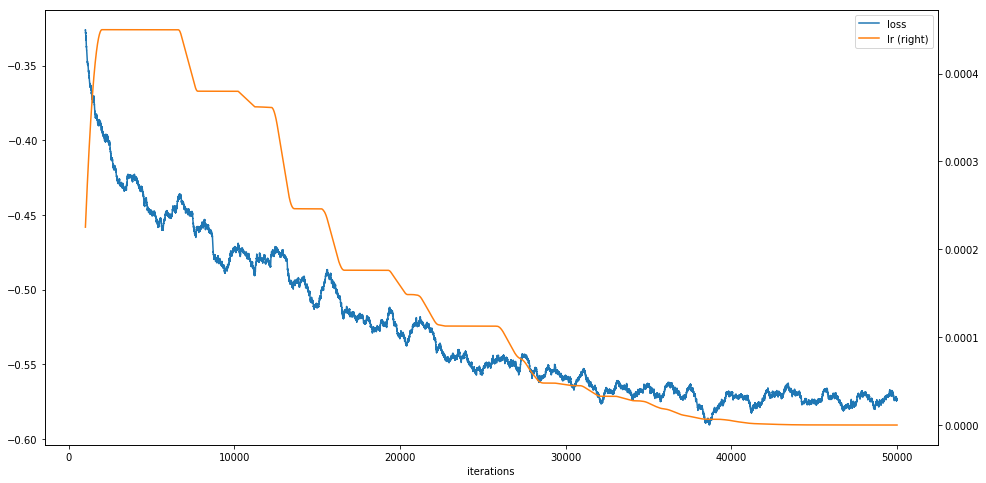

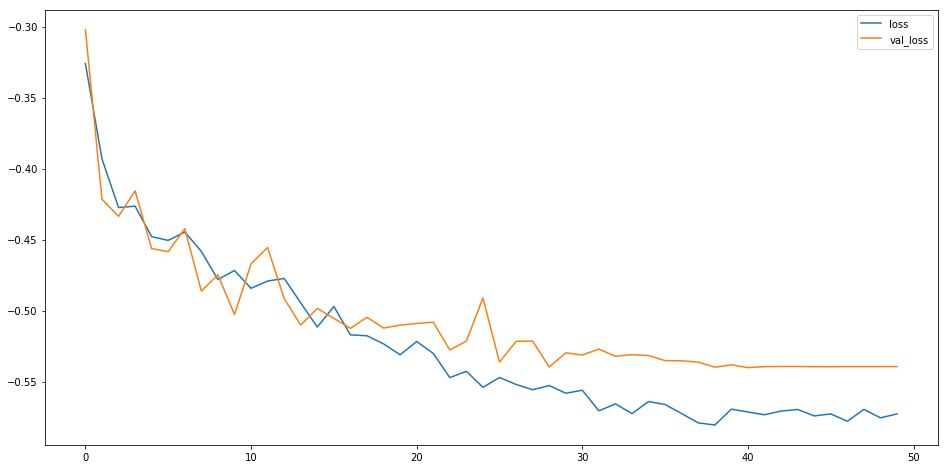

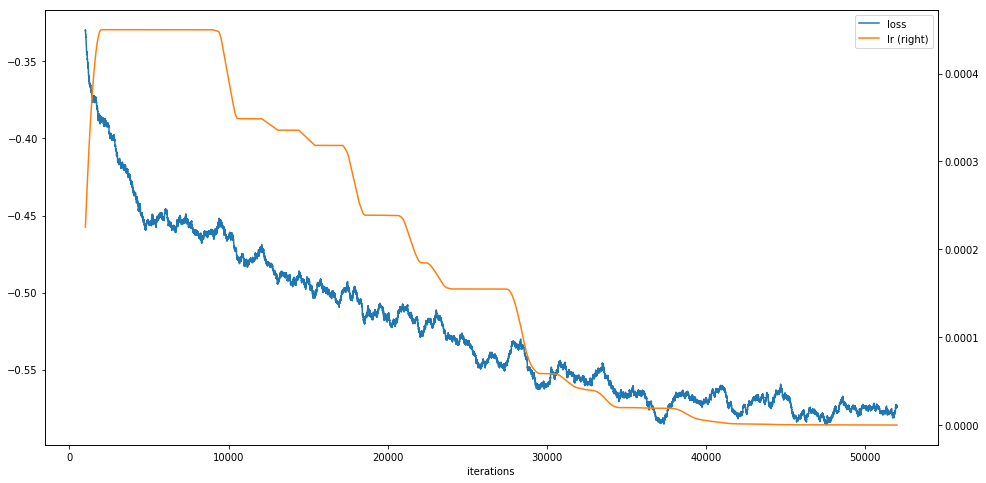

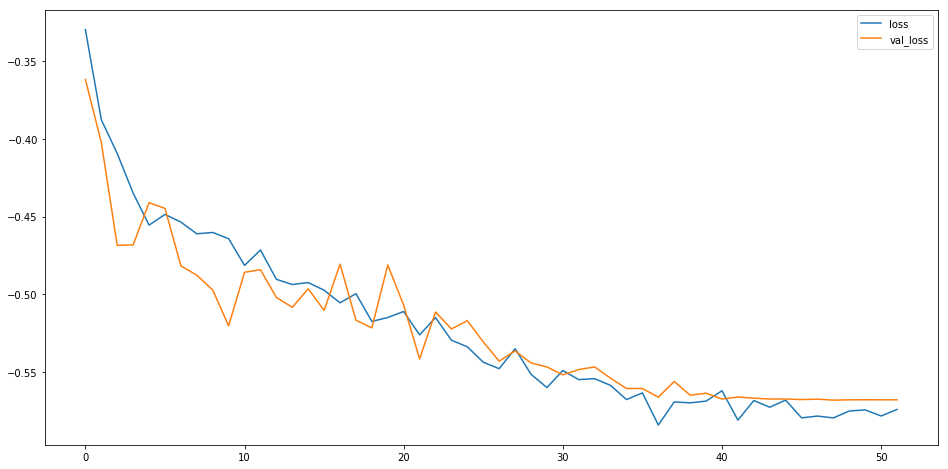

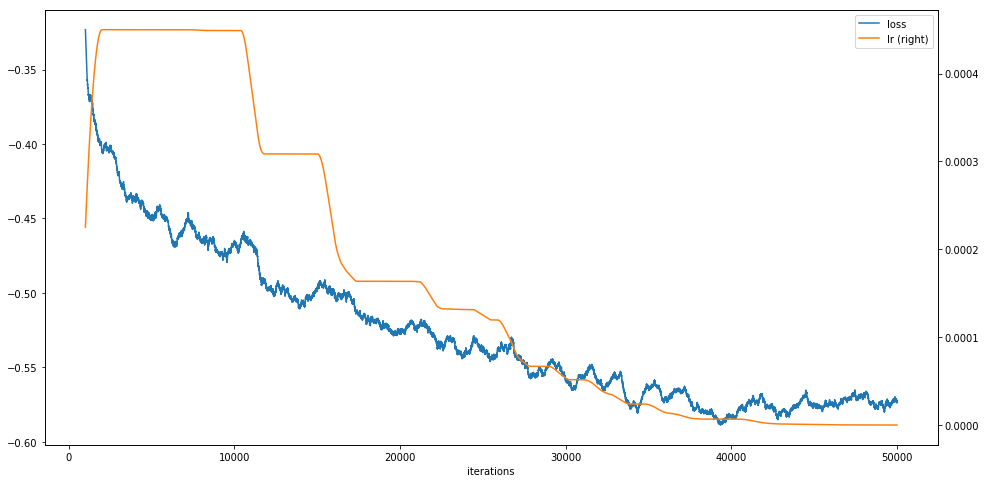

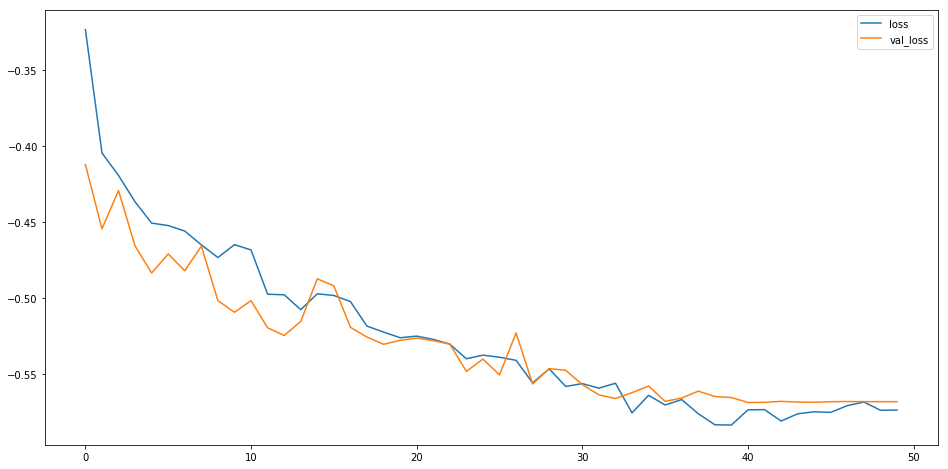

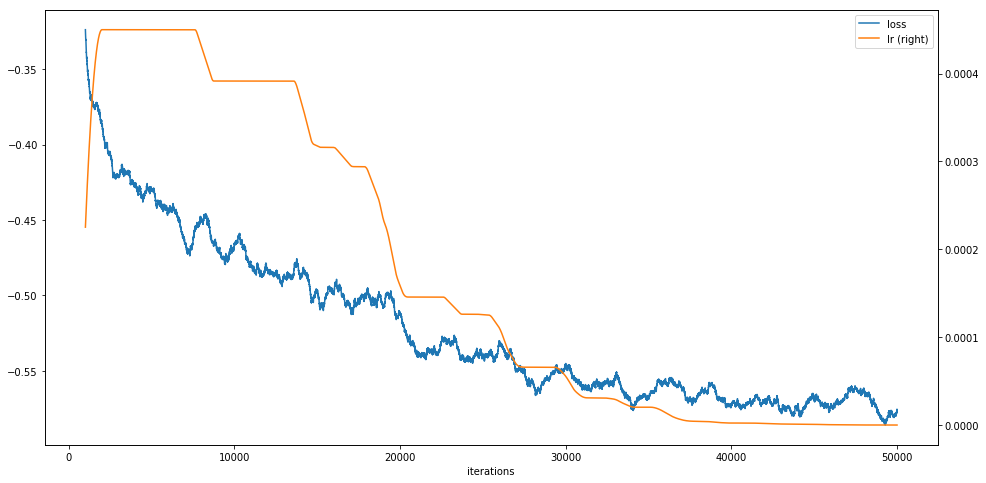

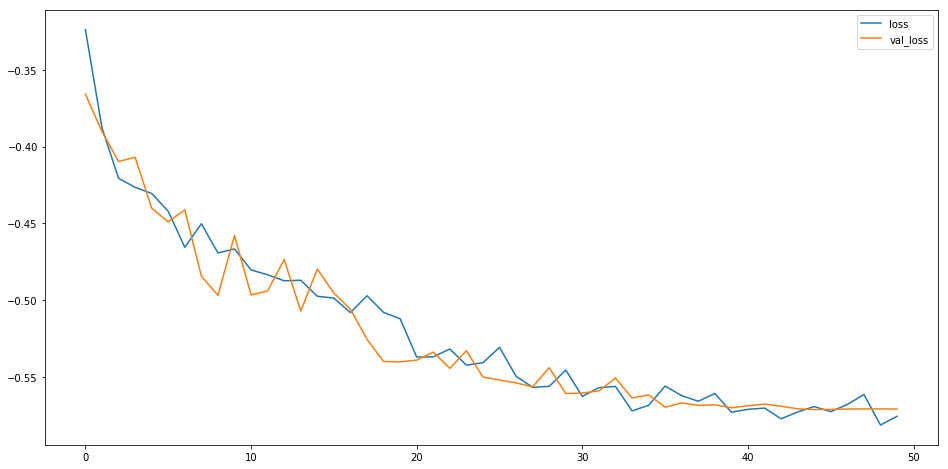

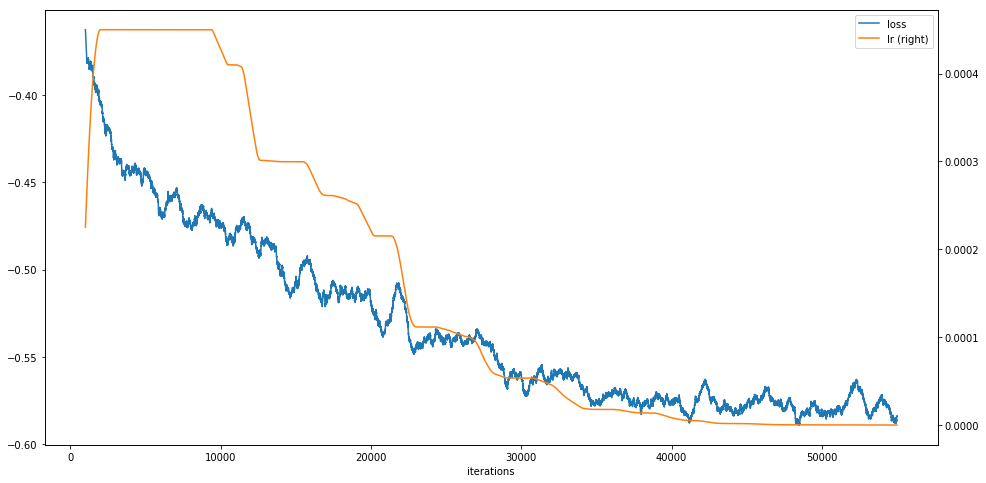

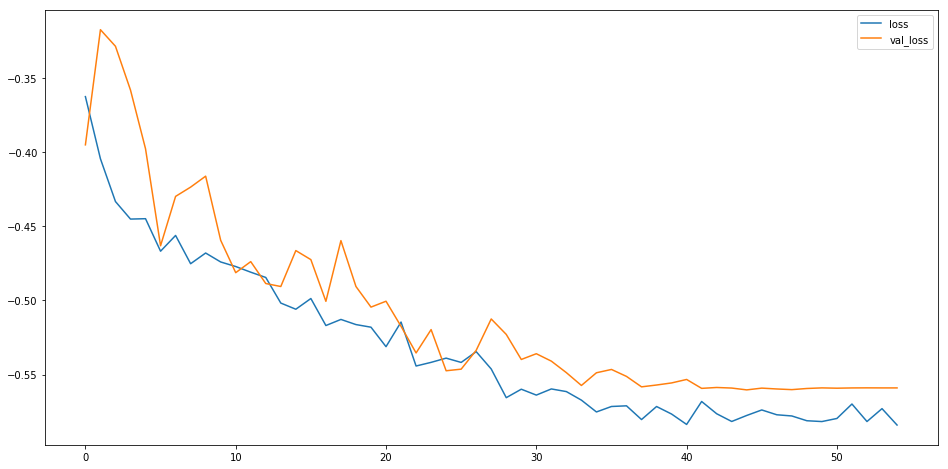

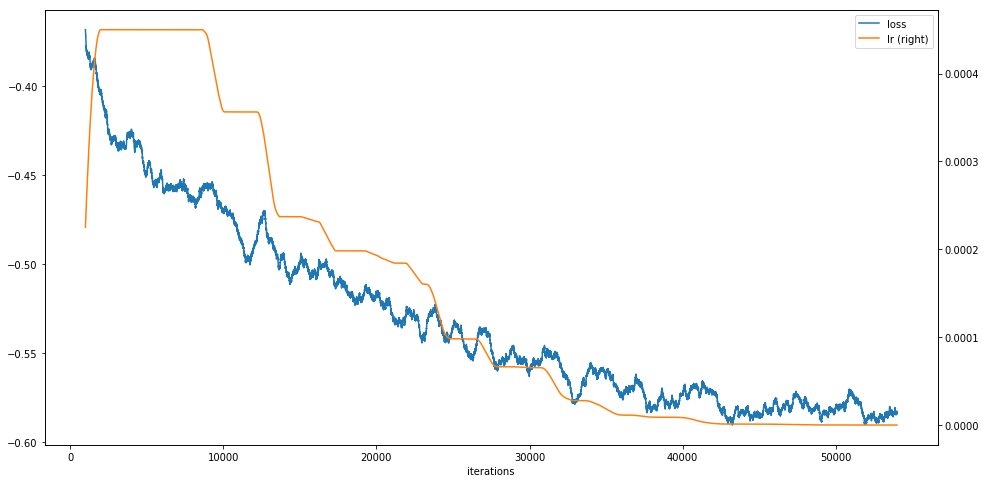

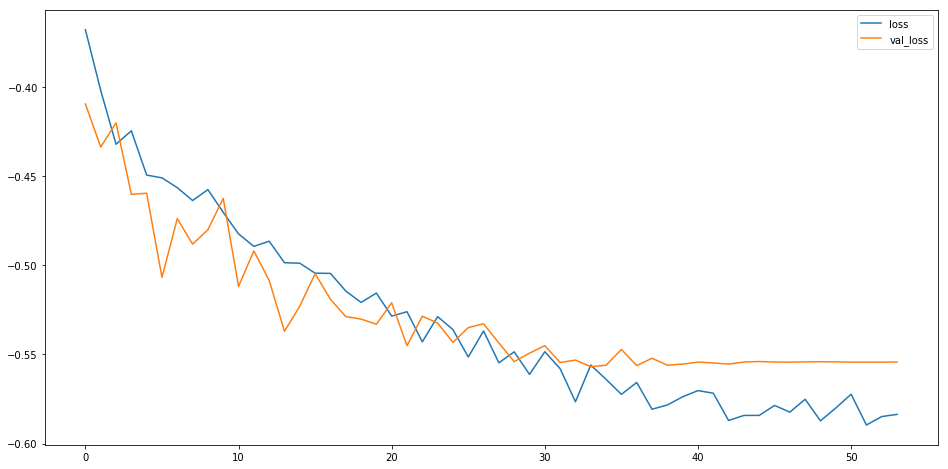

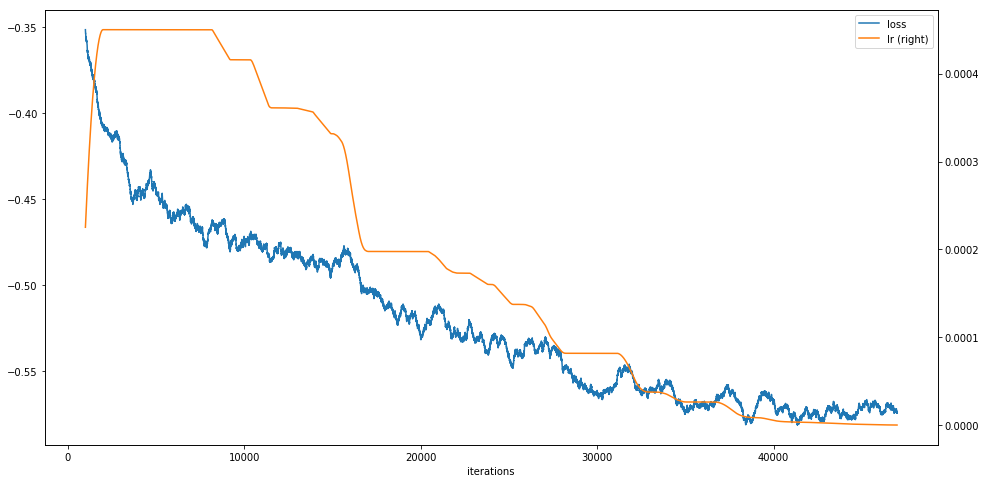

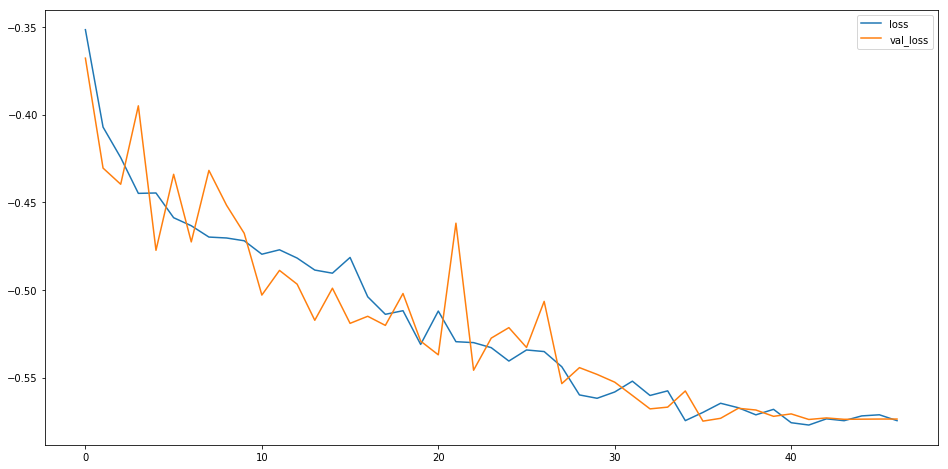

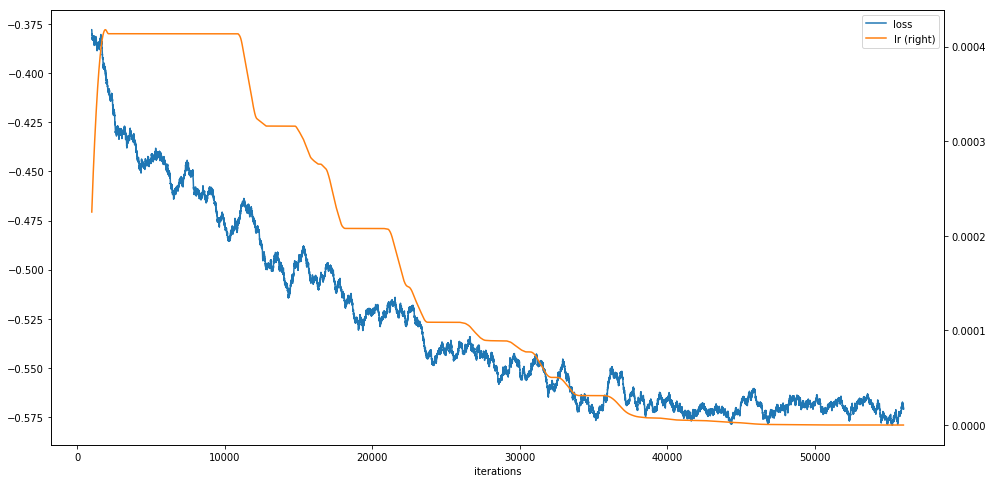

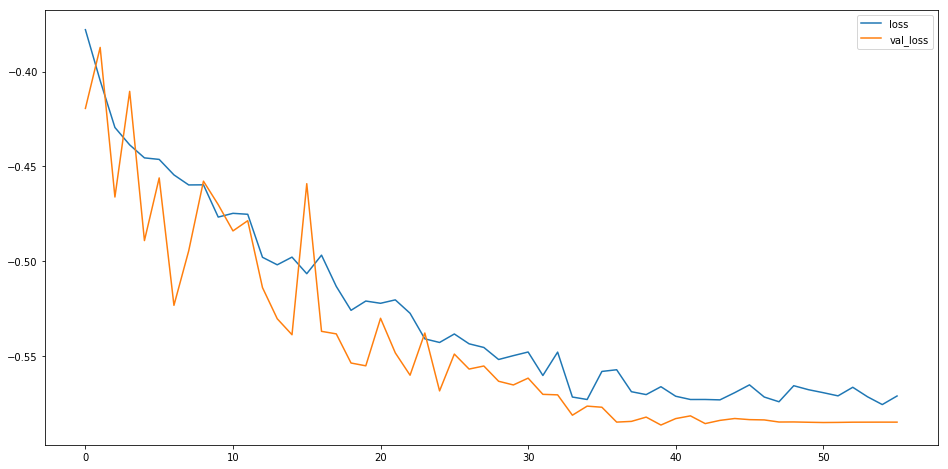

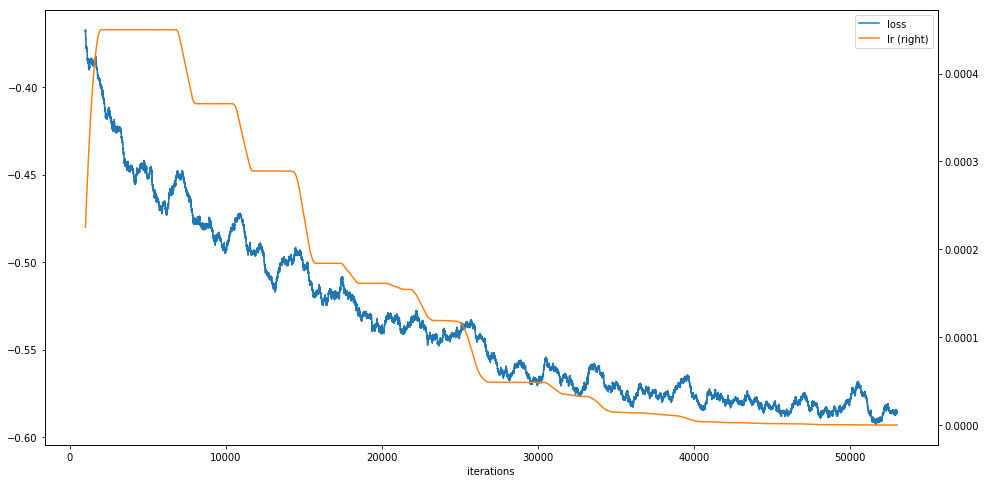

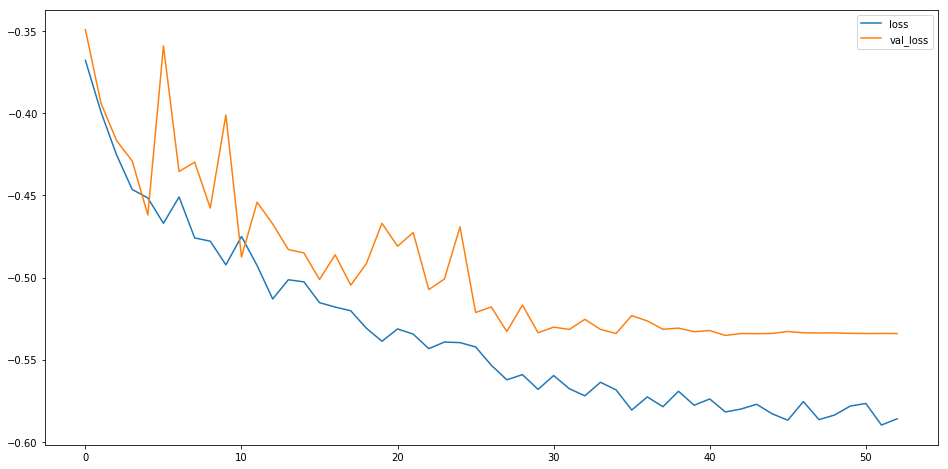

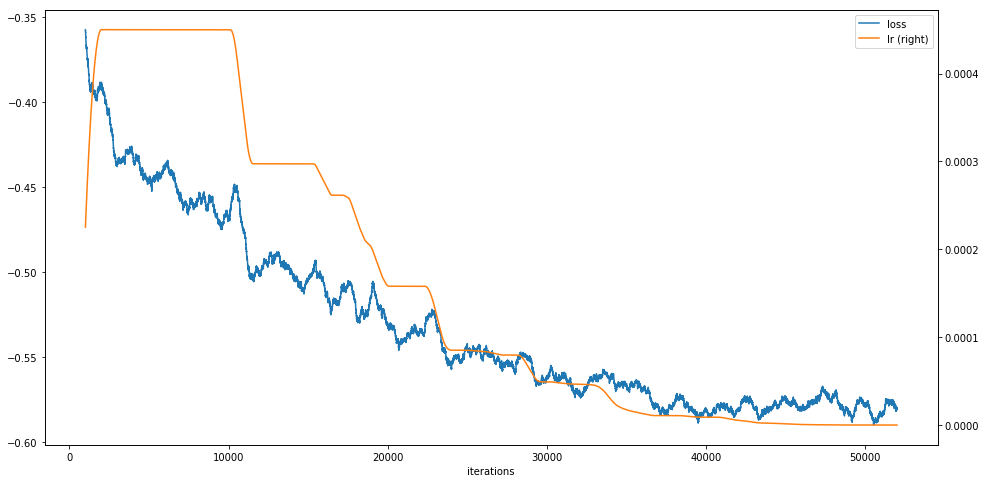

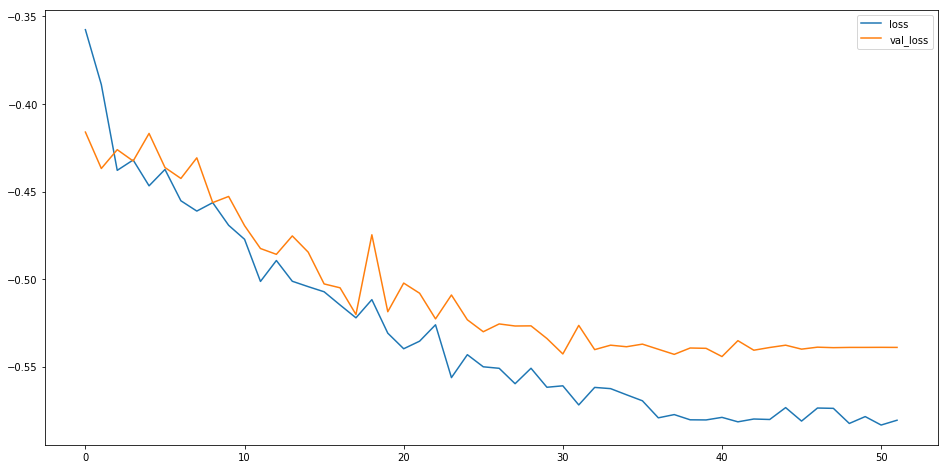

In [129]:
train_oof((votes, answers), votes_test)